# Project 5: NLP on Financial Statements
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. After implementing the function, run the cell to test it against the unit tests we've provided. For each problem, we provide one or more unit tests from our `project_tests` package. These unit tests won't tell you if your answer is correct, but will warn you of any major errors. Your code will be checked for the correct solution when you submit it to Udacity.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper` and `project_tests`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.

### Install Packages

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

    100% |████████████████████████████████| 18.9MB 2.1MB/s eta 0:00:01   10% |███▌                            | 2.1MB 21.9MB/s eta 0:00:01    16% |█████▏                          | 3.0MB 21.9MB/s eta 0:00:01    41% |█████████████▍                  | 7.9MB 23.6MB/s eta 0:00:01    54% |█████████████████▌              | 10.3MB 26.1MB/s eta 0:00:01    79% |█████████████████████████▌      | 15.0MB 22.7MB/s eta 0:00:01    85% |███████████████████████████▍    | 16.2MB 24.3MB/s eta 0:00:01    91% |█████████████████████████████▍  | 17.4MB 23.0MB/s eta 0:00:01    98% |███████████████████████████████▍| 18.6MB 26.5MB/s eta 0:00:01
    100% |████████████████████████████████| 1.4MB 8.5MB/s eta 0:00:01
    100% |████████████████████████████████| 17.0MB 2.0MB/s eta 0:00:01   33% |██████████▊                     | 5.7MB 25.6MB/s eta 0:00:01    53% |█████████████████▎              | 9.2MB 22.9MB/s eta 0:00:01    74% |███████████████████████▊        | 12.6MB 22.8MB/s eta 0:00:01
    100% |███████████████

  Found existing installation: tqdm 4.11.2
    Uninstalling tqdm-4.11.2:
      Successfully uninstalled tqdm-4.11.2


### Load Packages

In [2]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import project_helper
import project_tests

from tqdm import tqdm

### Download NLP Corpora
You'll need two corpora to run this project: the stopwords corpus for removing stopwords and wordnet for lemmatizing.

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Get 10ks
We'll be running NLP analysis on 10-k documents. To do that, we first need to download the documents. For this project, we'll download 10-ks for a few companies. To lookup documents for these companies, we'll use their CIK. If you would like to run this against other stocks, we've provided the dict `additional_cik` for more stocks. However, the more stocks you try, the long it will take to run.

In [4]:
cik_lookup = {
    'AMZN': '0001018724',
    'BMY': '0000014272',   
    'CNP': '0001130310',
    'CVX': '0000093410',
    'FL': '0000850209',
    'FRT': '0000034903',
    'HON': '0000773840'}

additional_cik = {
    'AEP': '0000004904',
    'AXP': '0000004962',
    'BA': '0000012927', 
    'BK': '0001390777',
    'CAT': '0000018230',
    'DE': '0000315189',
    'DIS': '0001001039',
    'DTE': '0000936340',
    'ED': '0001047862',
    'EMR': '0000032604',
    'ETN': '0001551182',
    'GE': '0000040545',
    'IBM': '0000051143',
    'IP': '0000051434',
    'JNJ': '0000200406',
    'KO': '0000021344',
    'LLY': '0000059478',
    'MCD': '0000063908',
    'MO': '0000764180',
    'MRK': '0000310158',
    'MRO': '0000101778',
    'PCG': '0001004980',
    'PEP': '0000077476',
    'PFE': '0000078003',
    'PG': '0000080424',
    'PNR': '0000077360',
    'SYY': '0000096021',
    'TXN': '0000097476',
    'UTX': '0000101829',
    'WFC': '0000072971',
    'WMT': '0000104169',
    'WY': '0000106535',
    'XOM': '0000034088'}

### Get list of 10-ks
The SEC has a limit on the number of calls you can make to the website per second. In order to avoid hiding that limit, we've created the `SecAPI` class. This will cache data from the SEC and prevent you from going over the limit.

In [5]:
sec_api = project_helper.SecAPI()

With the class constructed, let's pull a list of filled 10-ks from the SEC for each company.

In [6]:
from bs4 import BeautifulSoup

def get_sec_data(cik, doc_type, start=0, count=60):
    newest_pricing_data = pd.to_datetime('2018-01-01')
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)
        if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_pricing_data]

    return entries

Let's pull the list using the `get_sec_data` function, then display some of the results. For displaying some of the data, we'll use Amazon as an example. 

In [7]:
example_ticker = 'AMZN'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

pprint.pprint(sec_data[example_ticker][:5])

[('https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm',
  '10-K',
  '2017-02-10'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872416000172/0001018724-16-000172-index.htm',
  '10-K',
  '2016-01-29'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872415000006/0001018724-15-000006-index.htm',
  '10-K',
  '2015-01-30'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872414000006/0001018724-14-000006-index.htm',
  '10-K',
  '2014-01-31'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000119312513028520/0001193125-13-028520-index.htm',
  '10-K',
  '2013-01-30')]


### Download 10-ks
As you see, this is a list of urls. These urls point to a file that contains metadata related to each filling. Since we don't care about the metadata, we'll pull the filling by replacing the url with the filling url.

In [8]:
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0001018724-17-000011.txt : 20170210
<SEC-HEADER>0001018724-17-000011.hdr.sgml : 20170210
<ACCEPTANCE-DATETIME>20170209175636
ACCESSION NUMBER:		0001018724-17-000011
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		92
CONFORMED PERIOD OF REPORT:	20161231
FILED AS OF DATE:		20170210
DATE AS OF CHANGE:		20170209

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			AMAZON COM INC
		CENTRAL INDEX KEY:			0001018724
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]
		IRS NUMBER:				911646860
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-22513
		FILM NUMBER:		17588807

	BUSINESS ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
		BUSINESS PHONE:		2062661000

	MAIL ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<S

### Get Documents
With theses fillings downloaded, we want to break them into their associated documents. These documents are sectioned off in the fillings with the tags `<DOCUMENT>` for the start of each document and `</DOCUMENT>` for the end of each document. There's no overlap with these documents, so each `</DOCUMENT>` tag should come after the `<DOCUMENT>` with no `<DOCUMENT>` tag in between.

Implement `get_documents` to return a list of these documents from a filling. Make sure not to include the tag in the returned document text.

In [20]:
import re


def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
    
    # TODO: Implement
    doc_tags = re.finditer('<DOCUMENT>(.|\s)*?<\/DOCUMENT>', text)
    print(doc_tags)
    
    extracted_docs = []
    for m in doc_tags:
        extracted_docs.append(text[m.start()+10:m.end()-11])
    return extracted_docs


project_tests.test_get_documents(get_documents)

Tests Passed


With the `get_documents` function implemented, let's extract all the documents.

In [21]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from AMZN Fillings:   0%|          | 0/17 [00:00<?, ?filling/s]

Getting Documents from AMZN Fillings:   6%|▌         | 1/17 [00:02<00:34,  2.17s/filling]

Getting Documents from AMZN Fillings:  12%|█▏        | 2/17 [00:03<00:29,  1.96s/filling]

Getting Documents from AMZN Fillings:  18%|█▊        | 3/17 [00:06<00:29,  2.10s/filling]

Getting Documents from AMZN Fillings:  24%|██▎       | 4/17 [00:08<00:27,  2.13s/filling]

Getting Documents from AMZN Fillings:  29%|██▉       | 5/17 [00:10<00:24,  2.05s/filling]

Getting Documents from AMZN Fillings:  35%|███▌      | 6/17 [00:11<00:21,  1.97s/filling]

Getting Documents from AMZN Fillings:  41%|████      | 7/17 [00:13<00:19,  1.90s/filling]

Getting Documents from AMZN Fillings:  47%|████▋     | 8/17 [00:13<00:15,  1.73s/filling]

Getting Documents from AMZN Fillings:  53%|█████▎    | 9/17 [00:14<00:12,  1.56s/filling]

Getting Documents from AMZN Fillings:  59%|█████▉    | 10/17 [00:14<00:10,  1.43s/filling]

Getting Documents from AMZN Fillings:  65%|██████▍   | 11/17 [00:14<00:07,  1.32s/filling]

Getting Documents from AMZN Fillings:  71%|███████   | 12/17 [00:14<00:06,  1.24s/filling]

Getting Documents from AMZN Fillings:  76%|███████▋  | 13/17 [00:15<00:04,  1.16s/filling]

Getting Documents from AMZN Fillings:  82%|████████▏ | 14/17 [00:15<00:03,  1.10s/filling]

Getting Documents from BMY Fillings:   0%|          | 0/23 [00:00<?, ?filling/s]

Getting Documents from BMY Fillings:   4%|▍         | 1/23 [00:04<01:39,  4.54s/filling]

Getting Documents from BMY Fillings:   9%|▊         | 2/23 [00:08<01:30,  4.33s/filling]

Getting Documents from BMY Fillings:  13%|█▎        | 3/23 [00:14<01:39,  4.96s/filling]

Getting Documents from BMY Fillings:  17%|█▋        | 4/23 [00:21<01:39,  5.25s/filling]

Getting Documents from BMY Fillings:  22%|██▏       | 5/23 [00:24<01:29,  4.96s/filling]

Getting Documents from BMY Fillings:  26%|██▌       | 6/23 [00:28<01:20,  4.74s/filling]

Getting Documents from BMY Fillings:  30%|███       | 7/23 [00:34<01:18,  4.94s/filling]

Getting Documents from BMY Fillings:  35%|███▍      | 8/23 [00:36<01:07,  4.50s/filling]

Getting Documents from BMY Fillings:  39%|███▉      | 9/23 [00:36<00:56,  4.07s/filling]

Getting Documents from BMY Fillings:  43%|████▎     | 10/23 [00:37<00:48,  3.71s/filling]

Getting Documents from BMY Fillings:  48%|████▊     | 11/23 [00:37<00:41,  3.42s/filling]

Getting Documents from BMY Fillings:  52%|█████▏    | 12/23 [00:38<00:34,  3.18s/filling]

Getting Documents from BMY Fillings:  57%|█████▋    | 13/23 [00:38<00:29,  2.97s/filling]

Getting Documents from BMY Fillings:  65%|██████▌   | 15/23 [00:39<00:20,  2.61s/filling]

Getting Documents from BMY Fillings:  78%|███████▊  | 18/23 [00:39<00:10,  2.19s/filling]

Getting Documents from CNP Fillings:   0%|          | 0/15 [00:00<?, ?filling/s]

Getting Documents from CNP Fillings:   7%|▋         | 1/15 [00:03<00:46,  3.35s/filling]

Getting Documents from CNP Fillings:  13%|█▎        | 2/15 [00:06<00:43,  3.36s/filling]

Getting Documents from CNP Fillings:  20%|██        | 3/15 [00:11<00:46,  3.86s/filling]

Getting Documents from CNP Fillings:  27%|██▋       | 4/15 [00:16<00:45,  4.10s/filling]

Getting Documents from CNP Fillings:  33%|███▎      | 5/15 [00:20<00:41,  4.11s/filling]

Getting Documents from CNP Fillings:  40%|████      | 6/15 [00:24<00:37,  4.14s/filling]

Getting Documents from CNP Fillings:  47%|████▋     | 7/15 [00:25<00:29,  3.67s/filling]

Getting Documents from CNP Fillings:  53%|█████▎    | 8/15 [00:27<00:23,  3.41s/filling]

Getting Documents from CNP Fillings:  60%|██████    | 9/15 [00:28<00:18,  3.12s/filling]

Getting Documents from CNP Fillings:  67%|██████▋   | 10/15 [00:28<00:14,  2.85s/filling]

Getting Documents from CNP Fillings:  80%|████████  | 12/15 [00:29<00:07,  2.42s/filling]

Getting Documents from CNP Fillings:  87%|████████▋ | 13/15 [00:29<00:04,  2.25s/filling]

Getting Documents from CNP Fillings:  93%|█████████▎| 14/15 [00:29<00:02,  2.11s/filling]

Getting Documents from CVX Fillings:   0%|          | 0/21 [00:00<?, ?filling/s]

Getting Documents from CVX Fillings:   5%|▍         | 1/21 [00:04<01:34,  4.73s/filling]

Getting Documents from CVX Fillings:  10%|▉         | 2/21 [00:08<01:23,  4.39s/filling]

Getting Documents from CVX Fillings:  14%|█▍        | 3/21 [00:13<01:23,  4.64s/filling]

Getting Documents from CVX Fillings:  19%|█▉        | 4/21 [00:20<01:26,  5.07s/filling]

Getting Documents from CVX Fillings:  24%|██▍       | 5/21 [00:30<01:36,  6.01s/filling]

Getting Documents from CVX Fillings:  29%|██▊       | 6/21 [00:32<01:21,  5.45s/filling]

Getting Documents from CVX Fillings:  33%|███▎      | 7/21 [00:36<01:12,  5.18s/filling]

Getting Documents from CVX Fillings:  38%|███▊      | 8/21 [00:37<01:00,  4.68s/filling]

Getting Documents from CVX Fillings:  43%|████▎     | 9/21 [00:38<00:51,  4.27s/filling]

Getting Documents from CVX Fillings:  48%|████▊     | 10/21 [00:38<00:42,  3.89s/filling]

Getting Documents from CVX Fillings:  52%|█████▏    | 11/21 [00:39<00:35,  3.58s/filling]

Getting Documents from CVX Fillings:  57%|█████▋    | 12/21 [00:39<00:29,  3.32s/filling]

Getting Documents from CVX Fillings:  62%|██████▏   | 13/21 [00:40<00:24,  3.10s/filling]

Getting Documents from CVX Fillings:  67%|██████▋   | 14/21 [00:40<00:20,  2.90s/filling]

Getting Documents from CVX Fillings:  76%|███████▌  | 16/21 [00:41<00:12,  2.57s/filling]

Getting Documents from CVX Fillings:  86%|████████▌ | 18/21 [00:41<00:06,  2.30s/filling]

Getting Documents from FL Fillings:   0%|          | 0/16 [00:00<?, ?filling/s]

Getting Documents from FL Fillings:   6%|▋         | 1/16 [00:03<00:48,  3.24s/filling]

Getting Documents from FL Fillings:  12%|█▎        | 2/16 [00:05<00:41,  2.98s/filling]

Getting Documents from FL Fillings:  19%|█▉        | 3/16 [00:08<00:36,  2.84s/filling]

Getting Documents from FL Fillings:  25%|██▌       | 4/16 [00:11<00:33,  2.80s/filling]

Getting Documents from FL Fillings:  31%|███▏      | 5/16 [00:13<00:29,  2.68s/filling]

Getting Documents from FL Fillings:  38%|███▊      | 6/16 [00:15<00:26,  2.61s/filling]

Getting Documents from FL Fillings:  44%|████▍     | 7/16 [00:16<00:21,  2.40s/filling]

Getting Documents from FL Fillings:  50%|█████     | 8/16 [00:17<00:17,  2.14s/filling]

Getting Documents from FL Fillings:  56%|█████▋    | 9/16 [00:17<00:13,  1.93s/filling]

Getting Documents from FL Fillings:  62%|██████▎   | 10/16 [00:17<00:10,  1.76s/filling]

Getting Documents from FL Fillings:  69%|██████▉   | 11/16 [00:17<00:08,  1.62s/filling]

Getting Documents from FL Fillings:  75%|███████▌  | 12/16 [00:18<00:06,  1.51s/filling]

Getting Documents from FL Fillings:  81%|████████▏ | 13/16 [00:18<00:04,  1.42s/filling]

Getting Documents from FRT Fillings:   0%|          | 0/19 [00:00<?, ?filling/s]

Getting Documents from FRT Fillings:   5%|▌         | 1/19 [00:02<00:49,  2.73s/filling]

Getting Documents from FRT Fillings:  11%|█         | 2/19 [00:05<00:47,  2.81s/filling]

Getting Documents from FRT Fillings:  16%|█▌        | 3/19 [00:09<00:51,  3.24s/filling]

Getting Documents from FRT Fillings:  21%|██        | 4/19 [00:13<00:50,  3.37s/filling]

Getting Documents from FRT Fillings:  26%|██▋       | 5/19 [00:17<00:48,  3.44s/filling]

Getting Documents from FRT Fillings:  32%|███▏      | 6/19 [00:20<00:45,  3.49s/filling]

Getting Documents from FRT Fillings:  37%|███▋      | 7/19 [00:22<00:38,  3.17s/filling]

Getting Documents from FRT Fillings:  42%|████▏     | 8/19 [00:22<00:31,  2.82s/filling]

Getting Documents from FRT Fillings:  47%|████▋     | 9/19 [00:22<00:25,  2.55s/filling]

Getting Documents from FRT Fillings:  53%|█████▎    | 10/19 [00:23<00:21,  2.35s/filling]

Getting Documents from FRT Fillings:  58%|█████▊    | 11/19 [00:24<00:17,  2.18s/filling]

Getting Documents from FRT Fillings:  63%|██████▎   | 12/19 [00:24<00:14,  2.03s/filling]

Getting Documents from FRT Fillings:  68%|██████▊   | 13/19 [00:24<00:11,  1.90s/filling]

Getting Documents from FRT Fillings:  84%|████████▍ | 16/19 [00:25<00:04,  1.57s/filling]

Getting Documents from HON Fillings:   0%|          | 0/20 [00:00<?, ?filling/s]

Getting Documents from HON Fillings:   5%|▌         | 1/20 [00:03<01:07,  3.54s/filling]

Getting Documents from HON Fillings:  10%|█         | 2/20 [00:06<00:57,  3.18s/filling]

Getting Documents from HON Fillings:  15%|█▌        | 3/20 [00:10<00:57,  3.40s/filling]

Getting Documents from HON Fillings:  20%|██        | 4/20 [00:16<01:04,  4.05s/filling]

Getting Documents from HON Fillings:  25%|██▌       | 5/20 [00:20<01:01,  4.10s/filling]

Getting Documents from HON Fillings:  30%|███       | 6/20 [00:24<00:56,  4.05s/filling]

Getting Documents from HON Fillings:  35%|███▌      | 7/20 [00:30<00:56,  4.37s/filling]

Getting Documents from HON Fillings:  40%|████      | 8/20 [00:32<00:49,  4.12s/filling]

Getting Documents from HON Fillings:  45%|████▌     | 9/20 [00:33<00:40,  3.71s/filling]

Getting Documents from HON Fillings:  50%|█████     | 10/20 [00:33<00:33,  3.38s/filling]

Getting Documents from HON Fillings:  55%|█████▌    | 11/20 [00:34<00:27,  3.11s/filling]

Getting Documents from HON Fillings:  60%|██████    | 12/20 [00:34<00:23,  2.89s/filling]

Getting Documents from HON Fillings:  65%|██████▌   | 13/20 [00:35<00:18,  2.69s/filling]

Getting Documents from HON Fillings:  75%|███████▌  | 15/20 [00:35<00:11,  2.36s/filling]

Getting Documents from HON Fillings: 100%|██████████| 20/20 [00:35<00:00,  1.79s/filling]

Document 0 Filed on 2017-02-10:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>amzn-20161231x10k.htm
<DESCRIPTION>FORM 10-K
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
	<he...

Document 1 Filed on 2017-02-10:

<TYPE>EX-12.1
<SEQUENCE>2
<FILENAME>amzn-20161231xex121.htm
<DESCRIPTION>COMPUTATION OF RATIO OF EARNINGS TO FIXED CHARGES
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http:...

Document 2 Filed on 2017-02-10:

<TYPE>EX-21.1
<SEQUENCE>3
<FILENAME>amzn-20161231xex211.htm
<DESCRIPTION>LIST OF SIGNIFICANT SUBSIDIARIES
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/h...


### Get Document Types
Now that we have all the documents, we want to find the 10-k form in this 10-k filing. Implement the `get_document_type` function to return the type of document given. The document type is located on a line with the `<TYPE>` tag. For example, a form of type "TEST" would have the line `<TYPE>TEST`. Make sure to return the type as lowercase, so this example would be returned as "test".

In [27]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    
    # TODO: Implement
    search = re.search(r'<TYPE>.+', doc)
    doc_type = doc[search.start()+6:search.end()].lower()
    return doc_type


project_tests.test_get_document_type(get_document_type)

Tests Passed


With the `get_document_type` function, we'll filter out all non 10-k documents.

In [28]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2016123...
    file_date: '2017-02-10'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2015123...
    file_date: '2016-01-29'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2014123...
    file_date: '2015-01-30'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2013123...
    file_date: '2014-01-31'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>d445434d10k....
    file_date: '2013-01-30'},
]


## Preprocess the Data
### Clean Up
As you can see, the text for the documents are very messy. To clean this up, we'll remove the html and lowercase all the text.

In [29]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

Using the `clean_text` function, we'll clean up all the documents.

In [30]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning HON 10-Ks: 100%|██████████| 20/20 [01:04<00:00,  3.22s/10-K]

[
  {
    file_clean: '\n10-k\n1\namzn-20161231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20151231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20141231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20131231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\nd445434d10k.htm\nform 10-k\n\n\nform 1...},
]


### Lemmatize
With the text cleaned up, it's time to distill the verbs down. Implement the `lemmatize_words` function to lemmatize verbs in the list of words provided.

In [34]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    
    # TODO: Implement
    
    lemmatizer = WordNetLemmatizer() 
    lemmatized_words = []
    for word in words:
        lemmatized_words.append(lemmatizer.lemmatize(word, 'v'))
    
    return lemmatized_words


project_tests.test_lemmatize_words(lemmatize_words)

Tests Passed


With the `lemmatize_words` function implemented, let's lemmatize all the data.

In [35]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize HON 10-Ks: 100%|██████████| 20/20 [00:05<00:00,  3.5710-K/s]

[
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20161231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20151231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20141231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20131231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'd445434d10k', 'htm', 'form', '1...},
]


### Remove Stopwords

In [36]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('Stop Words Removed')

Remove Stop Words for HON 10-Ks: 100%|██████████| 20/20 [00:02<00:00,  8.7910-K/s]

Stop Words Removed


## Analysis on 10ks
### Loughran McDonald Sentiment Word Lists
We'll be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining
- Superfluous
- Modal

This will allow us to do the sentiment analysis on the 10-ks. Let's first load these word lists. We'll be looking into a few of these sentiments.

In [37]:
import os


sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv(os.path.join('..', '..', 'data', 'project_5_loughran_mcdonald', 'loughran_mcdonald_master_dic_2016.csv'))
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')


sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


### Bag of Words
using the sentiment word lists, let's generate sentiment bag of words from the 10-k documents. Implement `get_bag_of_words` to generate a bag of words that counts the number of sentiment words in each doc. You can ignore words that are not in `sentiment_words`.

In [92]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    #words = sentiment_words['word']
    
    vectorizer = CountVectorizer(vocabulary = sentiment_words)
    bag_of_words = vectorizer.fit_transform(docs).toarray()

    return bag_of_words


project_tests.test_get_bag_of_words(get_bag_of_words)

Tests Passed


Using the `get_bag_of_words` function, we'll generate a bag of words for all the documents.

In [70]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}


project_helper.print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[ 0  1  0 ..., 11  0  0]\n [ 1  1  0 ..., 13  0 ...
    positive: '[[16  3  5 ...,  1  0  0]\n [16  3  5 ...,  1  0 ...
    uncertainty: '[[ 0  8  0 ...,  1  1  3]\n [ 0  7  0 ...,  1  1 ...
    litigious: '[[47 12 18 ...,  0  0  0]\n [56 14 18 ...,  0  0 ...
    constraining: '[[ 0  1  5 19  0 10  0  0  1  5  4  0  0  3 19  2...
    interesting: '[[  2   6   2   1  11   2   0 118  13   1   1   2...},
]


### Jaccard Similarity
Using the bag of words, let's calculate the jaccard similarity on the bag of words and plot it over time. Implement `get_jaccard_similarity` to return the jaccard similarities between each tick in time. Since the input, `bag_of_words_matrix`, is a bag of words for each time period in order, you just need to compute the jaccard similarities for each neighboring bag of words. Make sure to turn the bag of words into a boolean array when calculating the jaccard similarity.

In [88]:
from sklearn.metrics import jaccard_similarity_score


def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    
    # TODO: Implement

    bag_of_words = bag_of_words_matrix.astype(bool)
    zipped = zip(bag_of_words,bag_of_words[1:])
    jaccard_similarities = [jaccard_similarity_score(a,b) for a, b in zipped]
  
    #print(jaccard_similarities)
    return jaccard_similarities


project_tests.test_get_jaccard_similarity(get_jaccard_similarity)

Tests Passed


Using the `get_jaccard_similarity` function, let's plot the similarities over time.

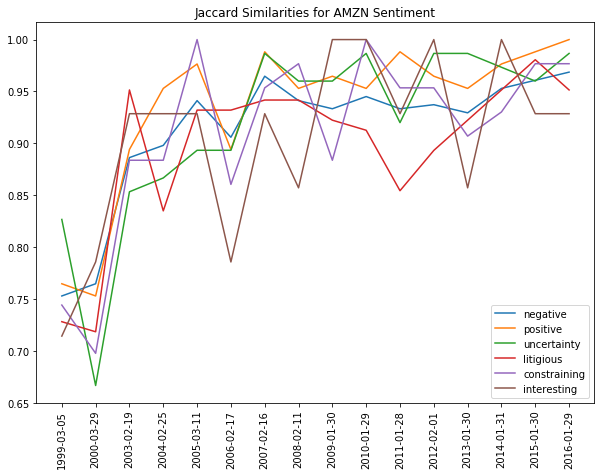

In [89]:
# Get dates for the universe
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}


project_helper.plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

### TFIDF
using the sentiment word lists, let's generate sentiment TFIDF from the 10-k documents. Implement `get_tfidf` to generate TFIDF from each document, using sentiment words as the terms. You can ignore words that are not in `sentiment_words`.

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    vectorizer = TfidfVectorizer(vocabulary = sentiment_words)
    tfidf = vectorizer.fit_transform(docs).toarray()

    return tfidf


project_tests.test_get_tfidf(get_tfidf)

Tests Passed


Using the `get_tfidf` function, let's generate the TFIDF values for all the documents.

In [94]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

    
project_helper.print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[ 0.          0.          0.         ...,  0.   ...
    positive: '[[ 0.22288432  0.          0.         ...,  0.   ...
    uncertainty: '[[ 0.          0.          0.         ...,  0.005...
    litigious: '[[ 0.  0.  0. ...,  0.  0.  0.]\n [ 0.  0.  0. .....
    constraining: '[[ 0.          0.          0.         ...,  0.   ...
    interesting: '[[ 0.01673784  0.          0.         ...,  0.   ...},
]


### Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [100]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    # TODO: Implement
    
    cosine_similarities = cosine_similarity(tfidf_matrix[0:], tfidf_matrix[1:])
    #print(tfidf_matrix)
    #print(cosine_similarities)
    return cosine_similarities[0].tolist()


project_tests.test_get_cosine_similarity(get_cosine_similarity)

Tests Passed


Let's plot the cosine similarities over time.

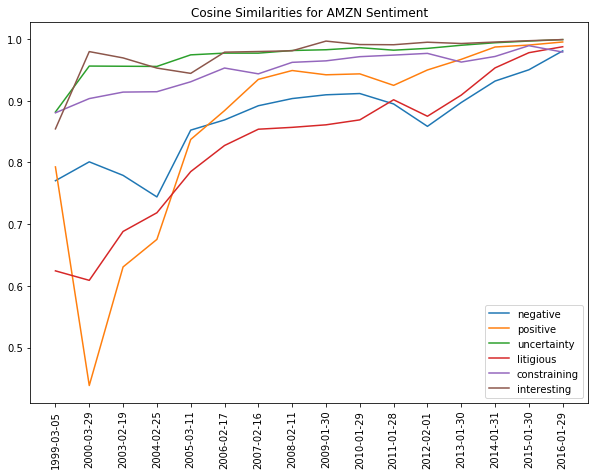

In [101]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


project_helper.plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

## Evaluate Alpha Factors
Just like we did in project 4, let's evaluate the alpha factors. For this section, we'll just be looking at the cosine similarities, but it can be applied to the jaccard similarities as well.
### Price Data
Let's get yearly pricing to run the factor against, since 10-Ks are produced annually.

In [102]:
pricing = pd.read_csv('../../data/project_5_yr/yr-quotemedia.csv', parse_dates=['date'])
pricing = pricing.pivot(index='date', columns='ticker', values='adj_close')


pricing

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,...,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,
1962-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1963-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1964-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1965-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1966-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1967-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1968-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1969-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1970-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Dict to DataFrame
The alphalens library uses dataframes, so we we'll need to turn our dictionary into a dataframe. 

In [103]:
cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}


for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment_name, sentiment_values in ten_k_sentiments.items():
        for sentiment_values, sentiment_value in enumerate(sentiment_values):
            cosine_similarities_df_dict['ticker'].append(ticker)
            cosine_similarities_df_dict['sentiment'].append(sentiment_name)
            cosine_similarities_df_dict['value'].append(sentiment_value)
            cosine_similarities_df_dict['date'].append(file_dates[ticker][1:][sentiment_values])

cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)
cosine_similarities_df['date'] = pd.DatetimeIndex(cosine_similarities_df['date']).year
cosine_similarities_df['date'] = pd.to_datetime(cosine_similarities_df['date'], format='%Y')


cosine_similarities_df.head()

,date,ticker,sentiment,value
0,2016-01-01,AMZN,negative,0.98065125
1,2015-01-01,AMZN,negative,0.95001565
2,2014-01-01,AMZN,negative,0.93176312
3,2013-01-01,AMZN,negative,0.89701433
4,2012-01-01,AMZN,negative,0.85838968


### Alphalens Format
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [104]:
import alphalens as al


factor_data = {}
skipped_sentiments = []

for sentiment in sentiments:
    cs_df = cosine_similarities_df[(cosine_similarities_df['sentiment'] == sentiment)]
    cs_df = cs_df.pivot(index='date', columns='ticker', values='value')

    try:
        data = al.utils.get_clean_factor_and_forward_returns(cs_df.stack(), pricing, quantiles=5, bins=None, periods=[1])
        factor_data[sentiment] = data
    except:
        skipped_sentiments.append(sentiment)

if skipped_sentiments:
    print('\nSkipped the following sentiments:\n{}'.format('\n'.join(skipped_sentiments)))
factor_data[sentiments[0]].head()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% en

1D     factor  factor_quantile
date       asset                                       
1994-01-01 BMY   0.53264104 0.44665176                1
           CVX   0.22211880 0.64730294                5
           FRT   0.17159556 0.46696523                3
1995-01-01 BMY   0.32152919 0.43571094                3
           CVX   0.28478156 0.62523346                5

### Alphalens Format with Unix Time
Alphalen's `factor_rank_autocorrelation` and `mean_return_by_quantile` functions require unix timestamps to work, so we'll also create factor dataframes with unix time.

In [105]:
unixt_factor_data = {
    factor: data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in data.index.values],
        names=['date', 'asset']))
    for factor, data in factor_data.items()}

### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

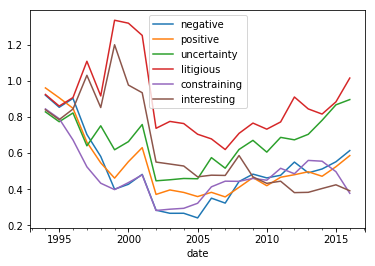

In [106]:
ls_factor_returns = pd.DataFrame()

for factor_name, data in factor_data.items():
    ls_factor_returns[factor_name] = al.performance.factor_returns(data).iloc[:, 0]

(1 + ls_factor_returns).cumprod().plot()

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8099c556d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f809a2e9390>]], dtype=object)

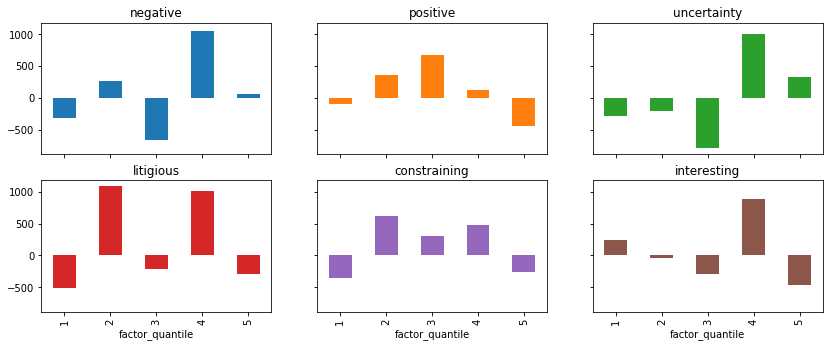

In [107]:
qr_factor_returns = pd.DataFrame()

for factor_name, data in unixt_factor_data.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False)

### Turnover Analysis
Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **Factor Rank Autocorrelation (FRA)**.

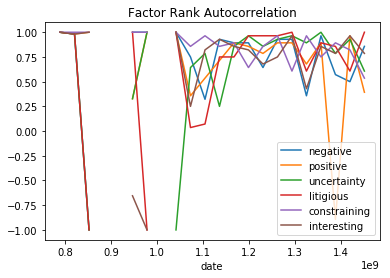

In [108]:
ls_FRA = pd.DataFrame()

for factor, data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

### Sharpe Ratio of the Alphas
The last analysis we'll do on the factors will be sharpe ratio. Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [109]:
daily_annualization_factor = np.sqrt(252)

(daily_annualization_factor * ls_factor_returns.mean() / ls_factor_returns.std()).round(2)

negative       -0.24000000
positive       -1.33000000
uncertainty     0.82000000
litigious       1.34000000
constraining   -2.99000000
interesting    -2.47000000
dtype: float64

That's it! You've successfully done sentiment analysis on 10-ks!
## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.